In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from numpy.random import normal, seed
import math
from sklearn.metrics import mean_squared_error

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from matplotlib import pyplot
from pylab import rcParams
from plotly import tools
import plotly.graph_objs as go
import plotly.figure_factory as ff
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import norm
import scipy.stats as scs
import os

!pip install Prophet

In [3]:
df = pd.read_csv("ICICIBANK.csv", parse_dates=["Date"],index_col="Date")
df.head()


,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,ICICIBANK,EQ,69.20,74.35,74.75,71.40,74.75,74.75,73.20,286260,2.095439e+12,NaN,NaN,NaN
2000-01-04,ICICIBANK,EQ,74.75,73.05,78.50,71.00,73.25,73.05,73.38,296264,2.173893e+12,NaN,NaN,NaN
2000-01-05,ICICIBANK,EQ,73.05,70.00,73.50,67.50,70.00,69.50,70.85,227624,1.612794e+12,NaN,NaN,NaN
2000-01-06,ICICIBANK,EQ,69.50,71.00,74.00,69.55,69.75,70.05,72.04,275149,1.982121e+12,NaN,NaN,NaN
2000-01-07,ICICIBANK,EQ,70.05,69.00,72.50,66.00,67.00,67.40,68.72,138809,9.538882e+11,NaN,NaN,NaN


In [4]:
df.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2021-04-26,ICICIBANK,EQ,569.95,602.00,605.50,588.0,588.7,591.10,596.22,62584522,3.731429e+15,546696.0,16913351.0,0.2702
2021-04-27,ICICIBANK,EQ,591.10,593.25,601.95,591.1,599.0,598.75,597.63,24239685,1.448630e+15,233412.0,9056247.0,0.3736
2021-04-28,ICICIBANK,EQ,598.75,598.00,622.80,598.0,619.7,621.35,612.57,33292864,2.039422e+15,295406.0,14011476.0,0.4209
2021-04-29,ICICIBANK,EQ,621.35,622.55,628.45,609.0,621.0,621.45,619.55,34537860,2.139792e+15,304029.0,10324897.0,0.2989
2021-04-30,ICICIBANK,EQ,621.45,610.10,616.35,598.1,599.7,600.50,607.02,23653258,1.435801e+15,247055.0,7292392.0,0.3083


In [5]:
df.shape

(5306, 14)

In [6]:
df.isna().sum()

,0
Symbol,0
Series,0
Prev Close,0
Open,0
High,0
Low,0
Last,0
Close,0
VWAP,0
Volume,0


In [7]:
print("Percentage of missing trade values = {:.2f}".format(100*(df['Trades'].isna().sum())/df.shape[0]))
print("Percentage of missing Deliverable Volume values = {:.2f}".format(100*(df['Deliverable Volume'].isna().sum())/df.shape[0]))
print("Percentage of missing %Deliverble values = {:.2f}".format(100*(df['%Deliverble'].isna().sum())/df.shape[0]))

Percentage of missing trade values = 53.71
Percentage of missing Deliverable Volume values = 9.74
Percentage of missing %Deliverble values = 9.74


In [8]:
df = df[df['Deliverable Volume'] >0]

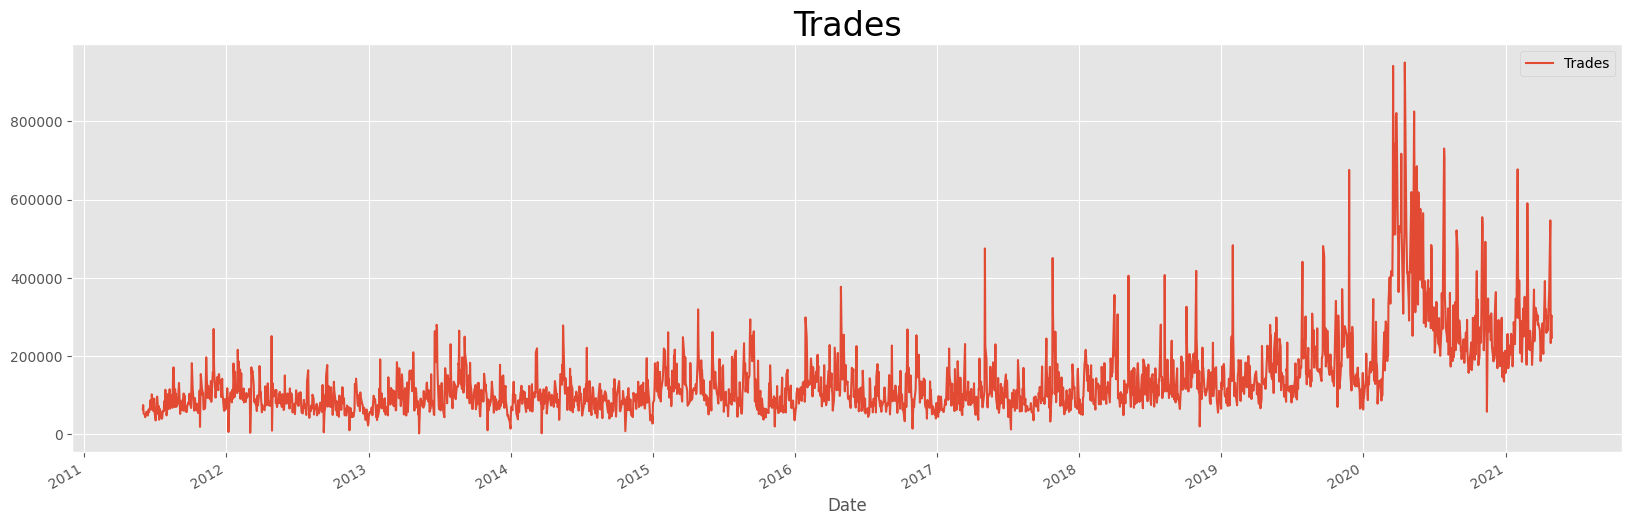

In [9]:
ax = df[['Trades']].plot(figsize=(20, 6))
ax.set_title('Trades', fontsize=24);

In [10]:
df['Trades'].ffill(axis = 0)
trade_data = df.loc[df.index<='2019']
mean = round(trade_data['Trades'].mean(),1)
df["Trades"].fillna(value = mean,inplace = True)

/tmp/ipython-input-1612129068.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





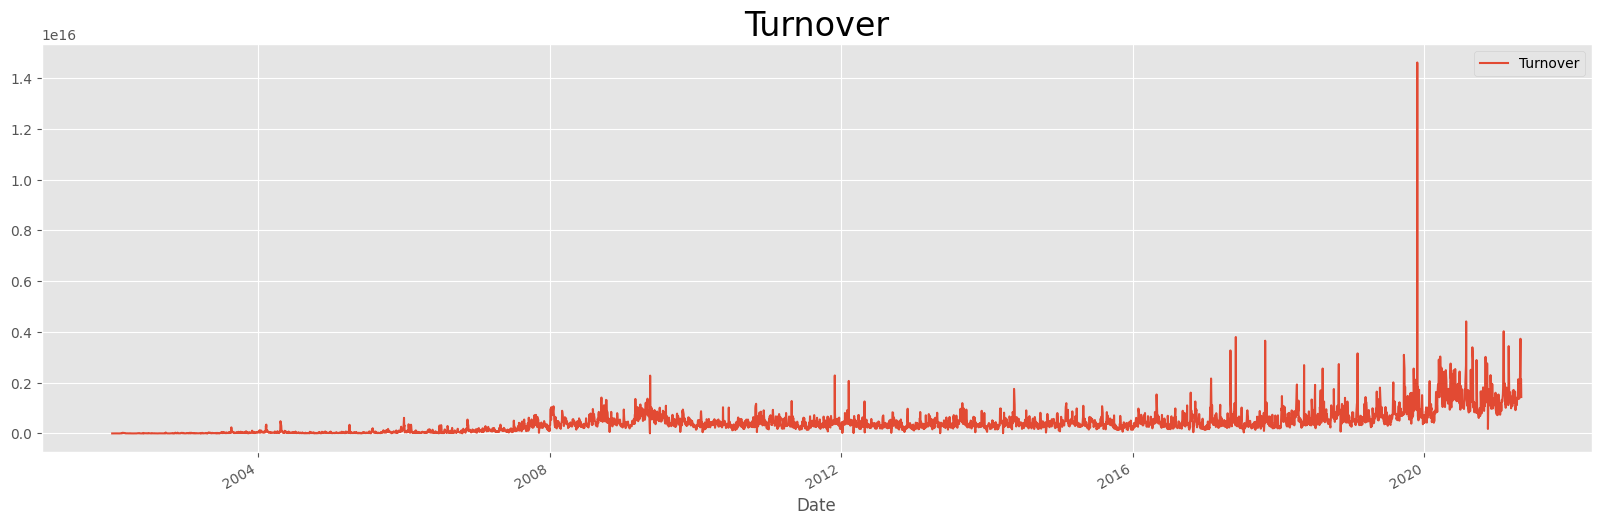

In [11]:
ax = df[['Turnover']].plot(figsize=(20, 6))
ax.set_title('Turnover', fontsize=24);

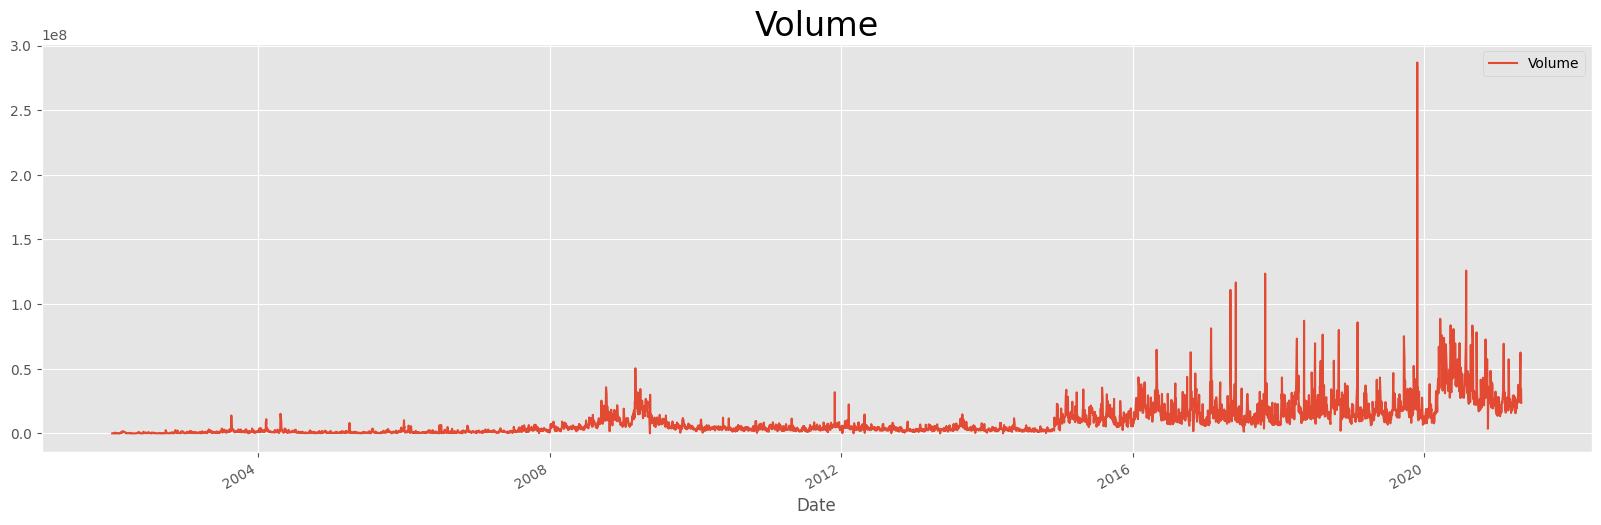

In [12]:
ax = df[['Volume']].plot(figsize=(20, 6))
ax.set_title('Volume', fontsize=24);

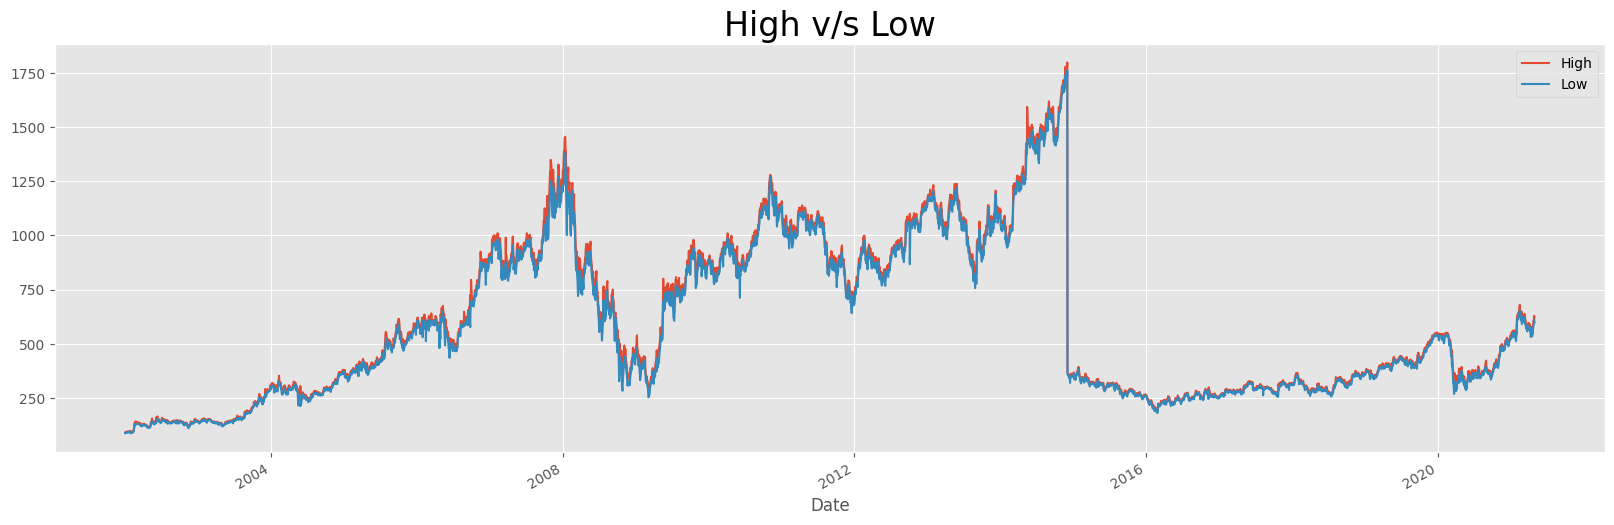

In [13]:
ax = df[['High', 'Low']].plot(figsize=(20, 6))
ax.set_title('High v/s Low', fontsize=24);

df['VWAP'].resample('A').mean().plot(kind='bar')
plt.title('End of year VWAP for ICICI bank')

/tmp/ipython-input-2181730537.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Text(0.5, 1.0, 'Monthly Mean 2015 VWAP for ICICI bank')

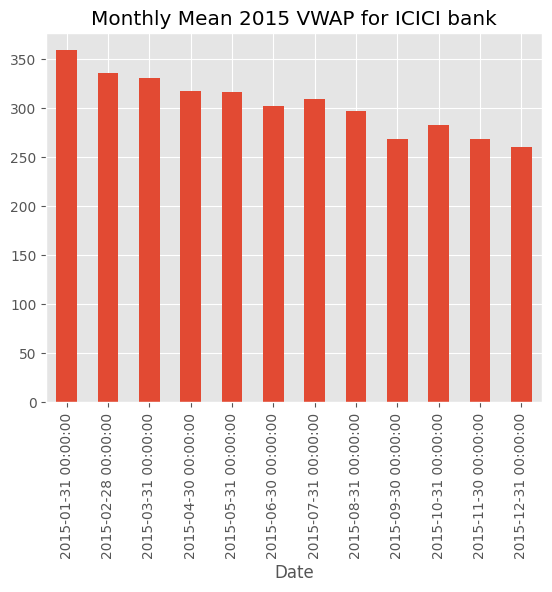

In [14]:
df['VWAP']['2015'].resample('M').mean().plot(kind='bar')
plt.title('Monthly Mean 2015 VWAP for ICICI bank')

/tmp/ipython-input-2357542913.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Text(0.5, 1.0, 'Monthly Mean 2020 VWAP for ICICI bank')

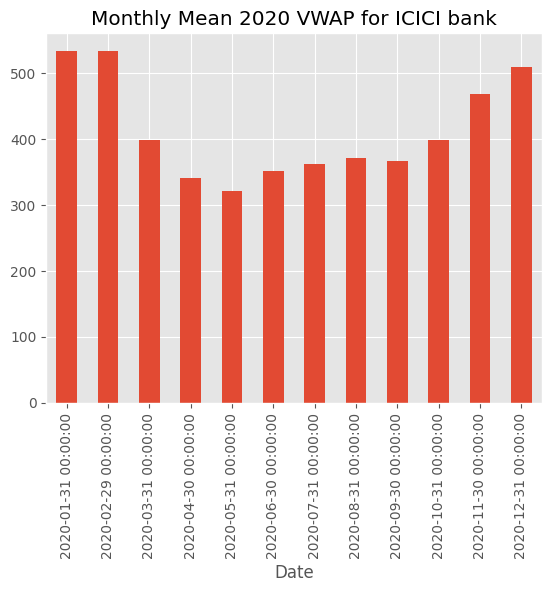

In [15]:
df['VWAP']['2020'].resample('M').mean().plot(kind='bar')
plt.title('Monthly Mean 2020 VWAP for ICICI bank')

Lambda: 0.179596


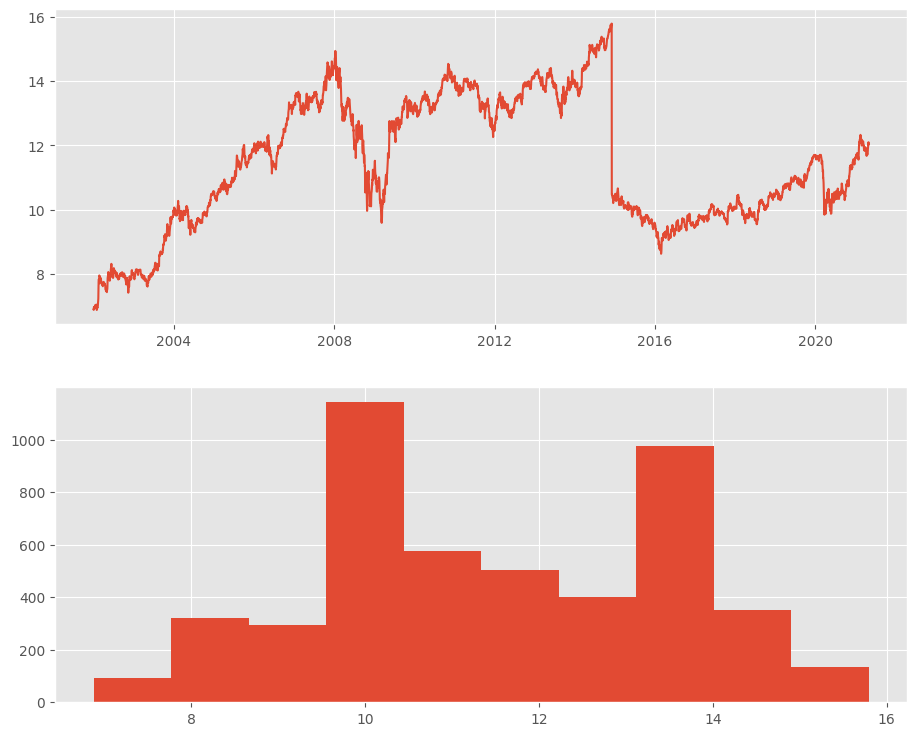

In [16]:
from scipy.stats import boxcox
df['vwap_boxcox'],lam = boxcox(df['VWAP'])
print('Lambda: %f' % lam)
rcParams['figure.figsize'] = 11, 9
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(df['vwap_boxcox'])
# histogram
pyplot.subplot(212)
pyplot.hist(df['vwap_boxcox'])
pyplot.show()

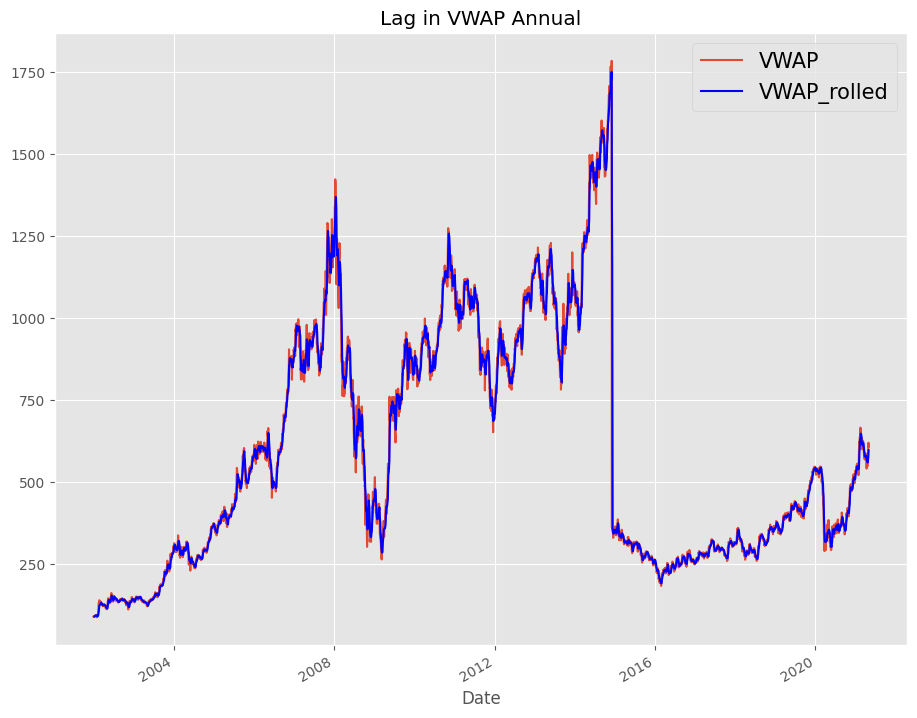

In [17]:
rolling_vwap = df['VWAP'].rolling(window=7)
df['VWAP_rolled'] = rolling_vwap.mean()
df['VWAP'].plot()
df['VWAP_rolled'].plot(color='blue')
plt.title('Lag in VWAP Annual')
plt.legend(fontsize=15)
pyplot.show()

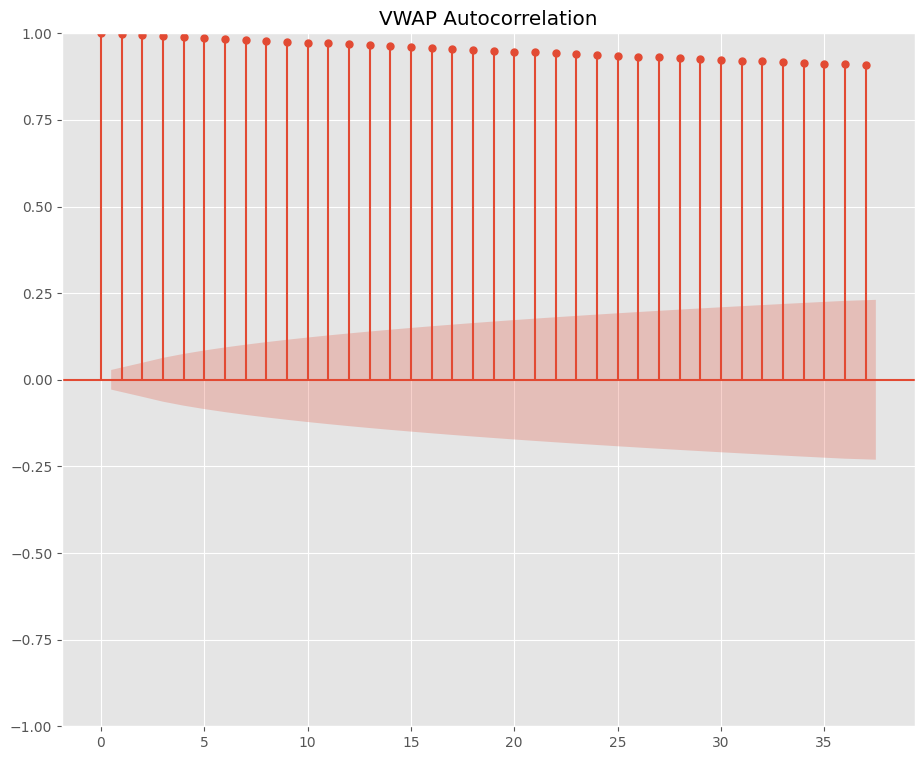

In [18]:
plot_acf(df['VWAP'],title="VWAP Autocorrelation")
plt.show()

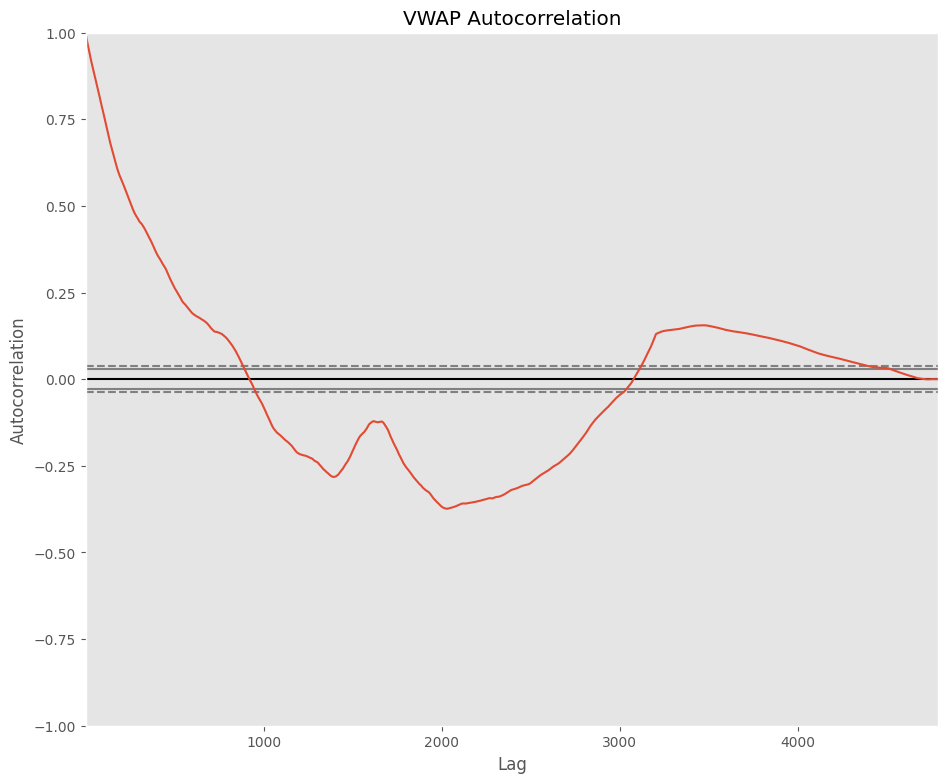

In [19]:
autocorrelation_plot(df['VWAP'])
plt.title('VWAP Autocorrelation')
pyplot.show()

Partial Autocorrelation

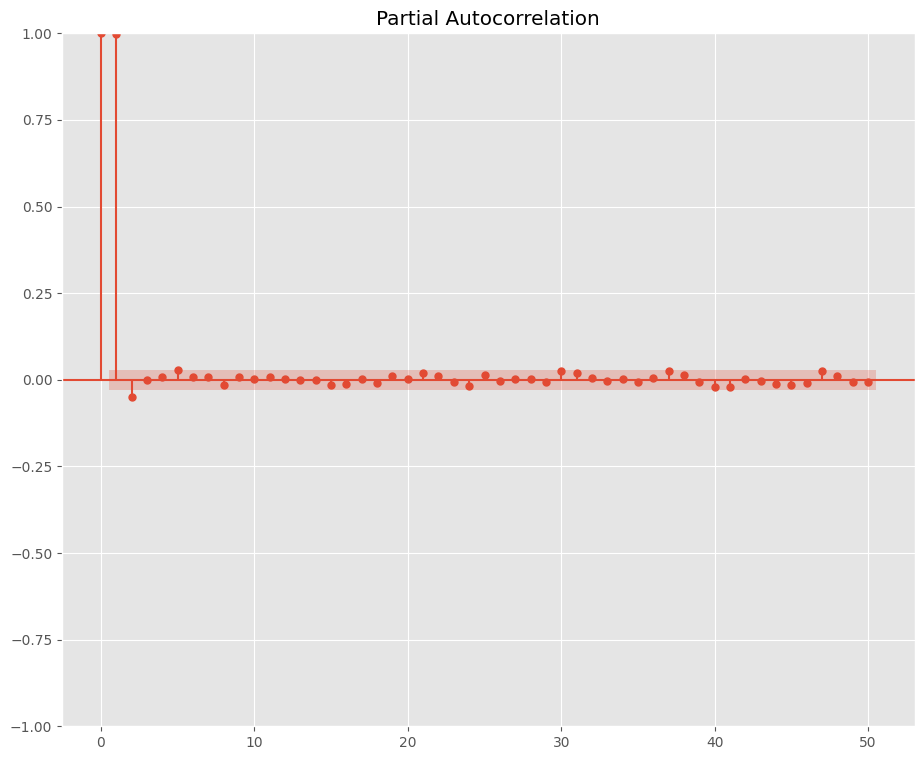

In [20]:
plot_pacf(df['VWAP'],lags=50)
plt.show()

In [21]:
result = adfuller(df['VWAP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.740467
p-value: 0.067294
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


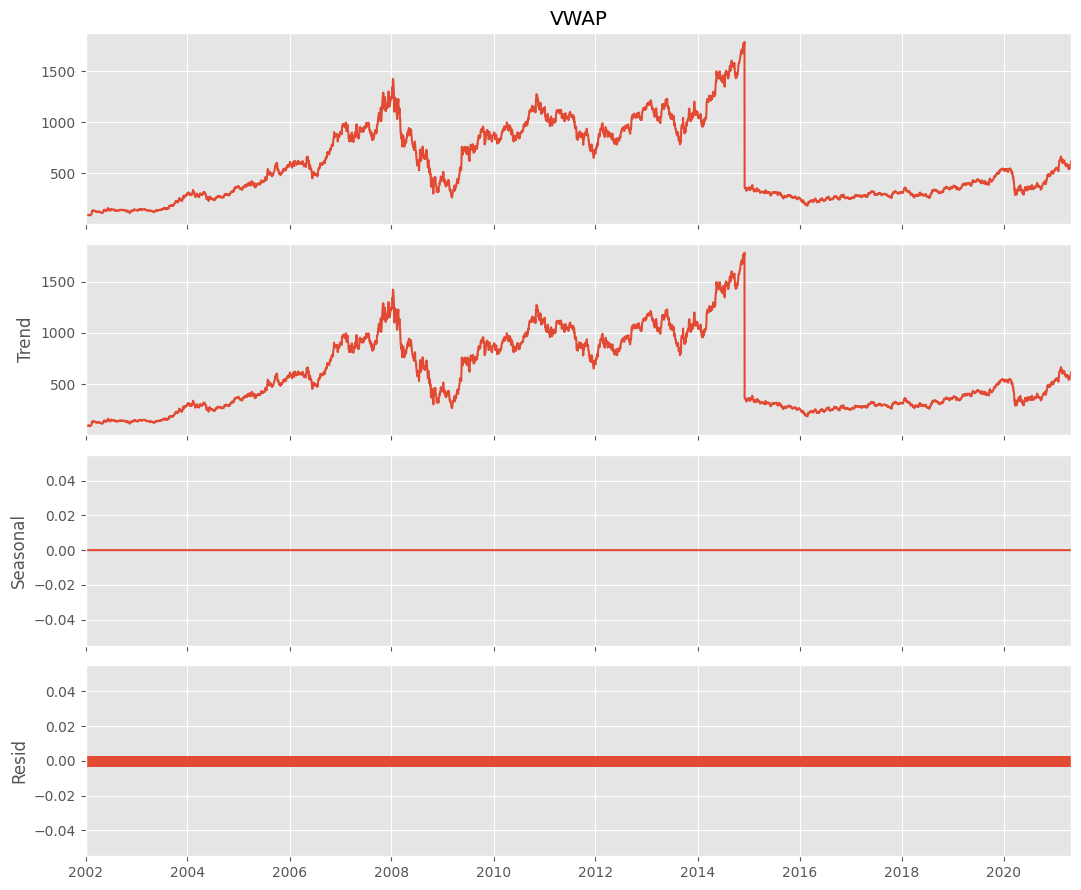

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = df['VWAP']
result = seasonal_decompose(series, model='additive', period=1)
rcParams['figure.figsize'] = 11, 9
result.plot()
pyplot.show()

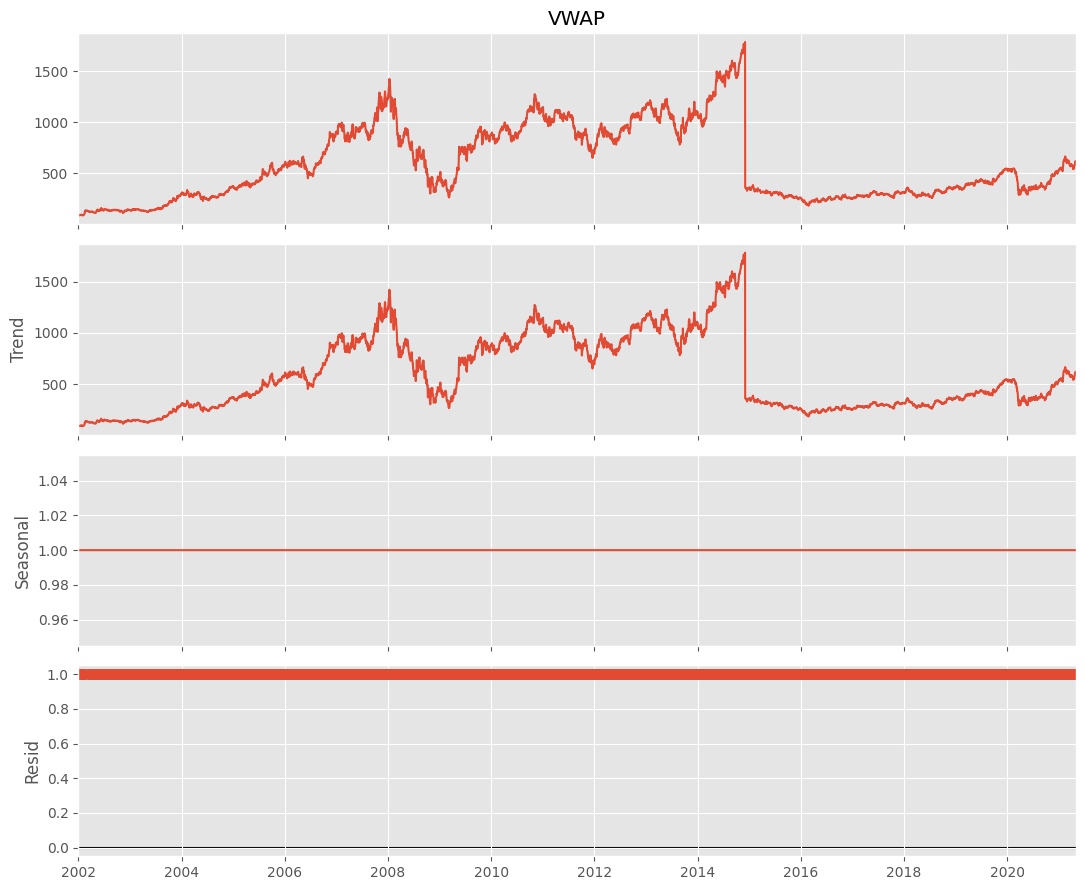

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = df['VWAP']
result = seasonal_decompose(series, model='multiplicative', period=1)
rcParams['figure.figsize'] = 11, 9
result.plot()
pyplot.show()

In [24]:
df2 = df.copy()
df2.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,vwap_boxcox,VWAP_rolled
Date,,,,,,,,,,,,,,,,
2002-01-01,ICICIBANK,EQ,88.7,89.95,89.95,87.30,88.05,88.50,88.53,47087,4.168734e+11,105660.5,35559.0,0.7552,6.888369,NaN
2002-01-02,ICICIBANK,EQ,88.5,88.00,89.00,87.50,87.60,88.40,88.05,70982,6.249913e+11,105660.5,64128.0,0.9034,6.876212,NaN
2002-01-03,ICICIBANK,EQ,88.4,86.60,92.95,86.60,92.05,92.00,90.40,143055,1.293277e+12,105660.5,114325.0,0.7992,6.935219,NaN
2002-01-04,ICICIBANK,EQ,92.0,92.50,93.20,90.00,91.90,91.10,91.43,89792,8.209558e+11,105660.5,73659.0,0.8203,6.960686,NaN
2002-01-07,ICICIBANK,EQ,91.1,91.00,92.50,89.25,91.05,90.15,90.58,151344,1.370891e+12,105660.5,123531.0,0.8162,6.939687,NaN


In [25]:
if not isinstance(df2.index, pd.DatetimeIndex):
    df2.index = pd.to_datetime(df2.index)
if 'Date' in df2.columns:
    df2.drop(columns=['Date'], inplace=True)
if not isinstance(df2.index, pd.DatetimeIndex):
    df2.reset_index(drop=False, inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30
df_rolled_3d = df2[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df2[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df2[lag_features].rolling(window=window3, min_periods=0)
df_mean_3d = df_rolled_3d.mean().shift(1).astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).astype(np.float32)
df_std_3d = df_rolled_3d.std().shift(1).astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).astype(np.float32)
for feature in lag_features:
    df2[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature].values
    df2[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature].values
    df2[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature].values

    df2[f"{feature}_std_lag{window1}"] = df_std_3d[feature].values
    df2[f"{feature}_std_lag{window2}"] = df_std_7d[feature].values
    df2[f"{feature}_std_lag{window3}"] = df_std_30d[feature].values
if 'Date' in df2.columns:
    df2.set_index("Date", inplace=True)
df2.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,...,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,ICICIBANK,EQ,88.7,89.95,89.95,87.30,88.05,88.50,88.53,47087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-02,ICICIBANK,EQ,88.5,88.00,89.00,87.50,87.60,88.40,88.05,70982,...,4.168734e+11,NaN,NaN,NaN,105660.5,105660.5,105660.5,NaN,NaN,NaN
2002-01-03,ICICIBANK,EQ,88.4,86.60,92.95,86.60,92.05,92.00,90.40,143055,...,5.209324e+11,1.471616e+11,1.471616e+11,1.471616e+11,105660.5,105660.5,105660.5,0.0,0.0,0.0
2002-01-04,ICICIBANK,EQ,92.0,92.50,93.20,90.00,91.90,91.10,91.43,89792,...,7.783807e+11,4.578942e+11,4.578942e+11,4.578942e+11,105660.5,105660.5,105660.5,0.0,0.0,0.0
2002-01-07,ICICIBANK,EQ,91.1,91.00,92.50,89.25,91.05,90.15,90.58,151344,...,7.890245e+11,3.435345e+11,3.744746e+11,3.744746e+11,105660.5,105660.5,105660.5,0.0,0.0,0.0


Months and Days are useful features to input in the model for predictions.

In [26]:
df2.index = pd.to_datetime(df2.index)

df2["month"] = df2.index.month
df2["day"] = df2.index.day

In [27]:
df2.dropna(axis=0, inplace=True)
df2 = df2[~df2.isin([np.nan, np.inf, -np.inf]).any(axis=1)]
df2.index = pd.to_datetime(df2.index)
df2_numeric = df2.select_dtypes(include=[np.number])
df2_resampled = df2_numeric.resample('MS').sum()
df_train = df2_resampled[df2_resampled.index < "2019"]
df_valid = df2_resampled[df2_resampled.index >= "2019"]
exogenous_features = [
    "High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
    "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3", "Turnover_std_lag3",
    "Trades_mean_lag3", "Trades_std_lag3",
    "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
    "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7", "Turnover_std_lag7",
    "Trades_mean_lag7", "Trades_std_lag7",
    "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
    "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30", "Turnover_std_lag30",
    "Trades_mean_lag30", "Trades_std_lag30",
    "month", "day"
]
missing_features = [col for col in exogenous_features if col not in df2_resampled.columns]
if missing_features:
    print("⚠️ Warning: These features are missing from df2_resampled:", missing_features)

In [28]:
df2.index = pd.to_datetime(df2.index)
existing_features = [col for col in exogenous_features if col in df2.columns]
df3 = df2[["VWAP"] + existing_features].copy()
df3.sort_index(inplace=True)
freq = pd.infer_freq(df3.index)
print("⏱️ Inferred frequency:", freq if freq else "Could not infer")

⏱️ Inferred frequency: Could not infer


In [29]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(df3.VWAP,lags=3, exog=df3[exogenous_features])
res = model.fit()
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                 4783
Model:                   AutoReg-X(3)   Log Likelihood              -22195.976
Method:               Conditional MLE   S.D. of innovations             25.143
Date:                Sun, 28 Sep 2025   AIC                          44465.952
Time:                        03:04:37   BIC                          44705.423
Sample:                             3   HQIC                         44550.074
                                 4783                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0019      0.003      0.708      0.479      -0.003       0.007
VWAP.L1                 1.0812      0.059     18.274      0.000       0.965       1.197
VWAP.L2         

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/tmp/ipython-input-1732909471.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [30]:
res = model.fit(cov_type="HC0")
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                 4783
Model:                   AutoReg-X(3)   Log Likelihood              -22195.976
Method:               Conditional MLE   S.D. of innovations             25.143
Date:                Sun, 28 Sep 2025   AIC                          44465.952
Time:                        03:04:45   BIC                          44705.423
Sample:                             3   HQIC                         44550.074
                                 4783                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0019      0.002      0.949      0.343      -0.002       0.006
VWAP.L1                 1.0812      0.082     13.264      0.000       0.921       1.241
VWAP.L2         

/tmp/ipython-input-2334598616.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



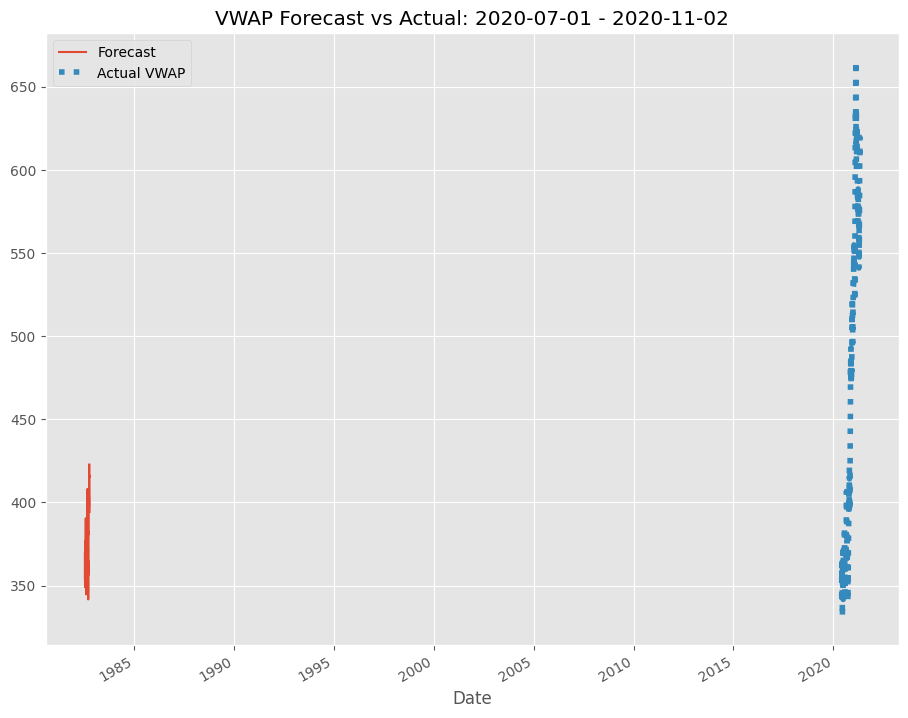

In [31]:
start_date = df3.index[df3.index.get_indexer([pd.Timestamp("2020-07-01")], method='nearest')[0]]
end_date = df3.index[df3.index.get_indexer([pd.Timestamp("2020-11-01")], method='nearest')[0]]
fig = res.plot_predict(start=start_date, end=end_date)
df3['VWAP'].loc[start_date - pd.DateOffset(months=1):].plot(
    ax=fig.gca(), linewidth=4, linestyle=':', label='Actual VWAP'
)

plt.title(f'VWAP Forecast vs Actual: {start_date.date()} - {end_date.date()}')
plt.legend()
plt.show()

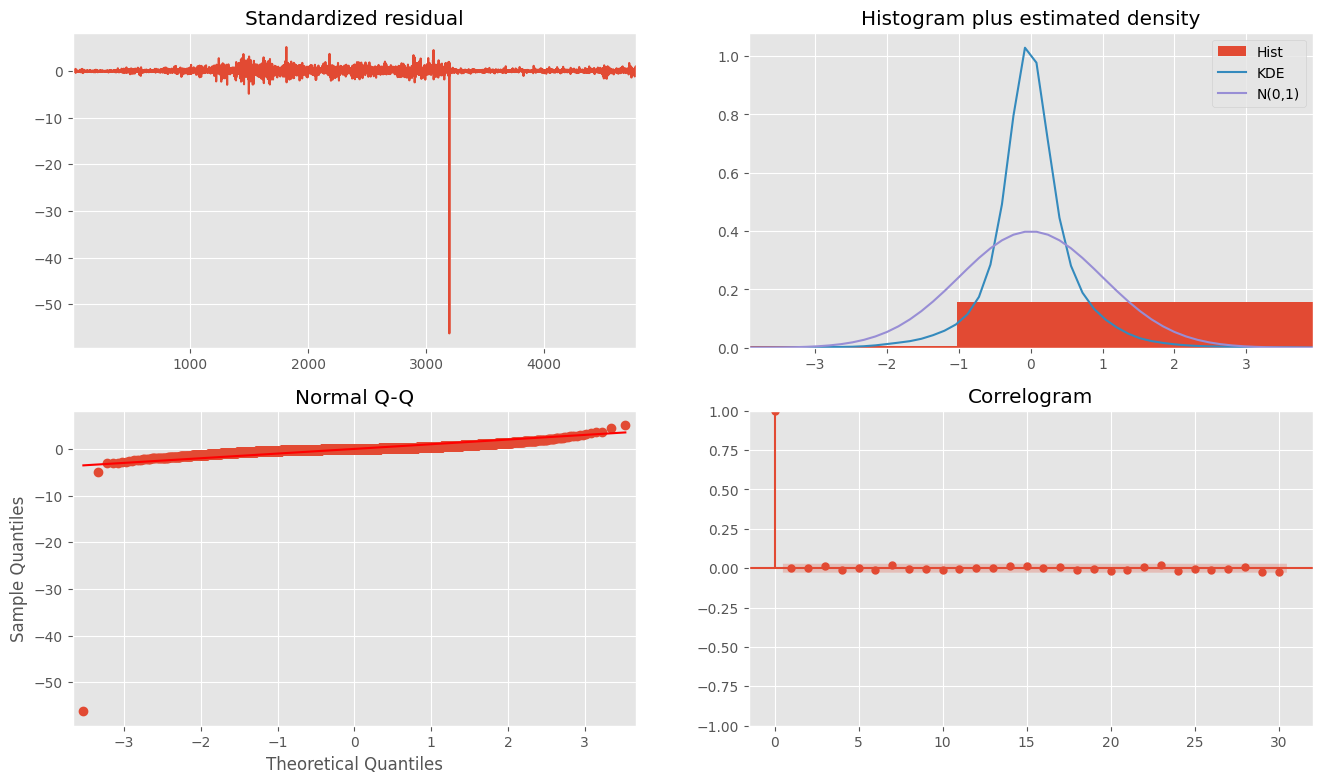

In [32]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [33]:
start_date = '2014-01-01'
end_date = '2020-11-02'
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(
    df3['VWAP'],
    order=(1, 1, 1),
    seasonal_order=(0, 0, 0, 0),
    exog=df3[exogenous_features],
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit(disp=False)
y_pred = res.predict(start=start_date, end=end_date, exog=df3[exogenous_features])
y_true = df3['VWAP'].loc[start_date:end_date]

comparison = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).dropna()
if not comparison.empty:
    rmse = math.sqrt(mean_squared_error(comparison['y_true'], comparison['y_pred']))
    print("✅ The root mean squared error is {:.2f}.".format(rmse))
else:
    print("⚠️ No valid data to calculate RMSE.")



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



✅ The root mean squared error is 35.95.


In [34]:
endog = df_train['VWAP']
exog_train = df_train[exogenous_features]
exog_valid = df_valid[exogenous_features]


In [35]:
model = SARIMAX(endog,
                exog=exog_train,
                order=(1,1,1),
                seasonal_order=(0,0,0,0),
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



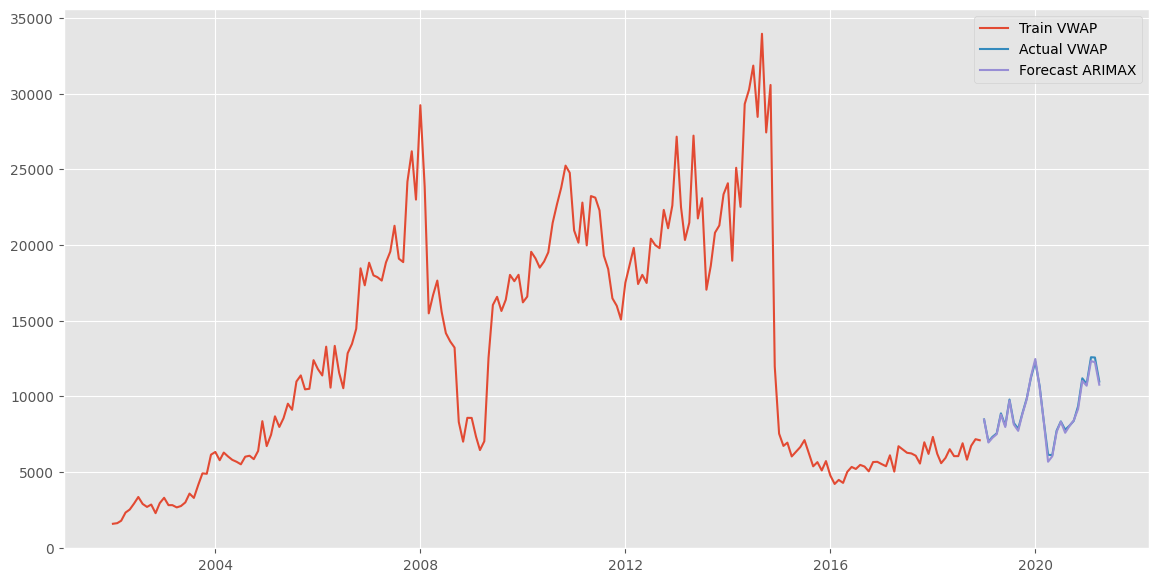

In [36]:
n_forecast = len(df_valid)
pred = res.get_forecast(steps=n_forecast, exog=exog_valid)
forecast = pred.predicted_mean
plt.figure(figsize=(14,7))
plt.plot(df_train.index, df_train.VWAP, label='Train VWAP')
plt.plot(df_valid.index, df_valid.VWAP, label='Actual VWAP')
plt.plot(df_valid.index, forecast, label='Forecast ARIMAX')
plt.legend(); plt.show()

In [37]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df3.values.astype('float32'))

train_size = int(len(scaled)*0.8)
train_data = scaled[:train_size]
test_data  = scaled[train_size:]

n_input = 10
batch_size = 32
generator = TimeseriesGenerator(train_data,
                                train_data[:,0],
                                length=n_input,
                                sampling_rate=1,
                                batch_size=batch_size)
test_gen  = TimeseriesGenerator(test_data,
                                test_data[:,0],
                                length=n_input,
                                sampling_rate=1,
                                batch_size=batch_size)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(n_input, train_data.shape[1]), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(generator,
                    epochs=50,
                    validation_data=test_gen,
                    callbacks=[es])


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0293 - val_loss: 0.0029
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030 - val_loss: 5.5242e-04
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 2.4762e-04
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - val_loss: 6.5524e-04
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 3.0320e-04
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023 - val_loss: 4.4429e-04
Epoch 9/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 5.4512e-04
Epoch 10/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - val_loss: 1.7185e-04
Epoch 11/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 3.4820e-04
Epoch 12/50
120/120 ━━━━━━━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
LSTM RMSE: 0.0100, MAE: 0.0069


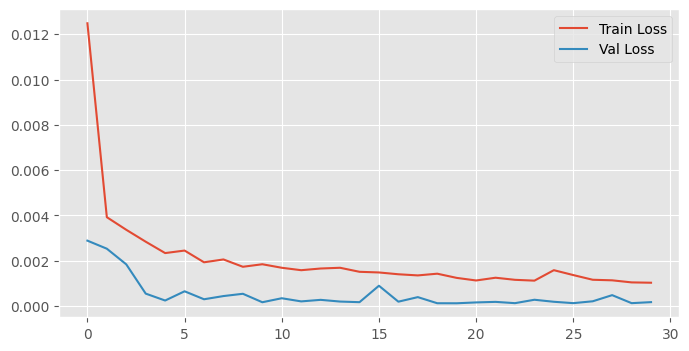

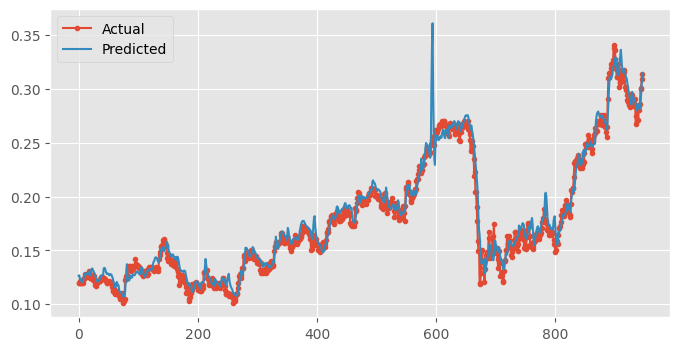

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

preds = model.predict(test_gen)

y_true = np.array([test_data[i:i+n_input,0][-1] for i in range(len(test_data)-n_input)])
rmse = np.sqrt(mean_squared_error(y_true, preds))
mae  = mean_absolute_error(y_true, preds)
print(f"LSTM RMSE: {rmse:.4f}, MAE: {mae:.4f}")

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(y_true, marker='.', label='Actual')
plt.plot(preds,      label='Predicted')
plt.legend(); plt.show()
